In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from scipy import signal
from datetime import timedelta
from matplotlib import cm
import torch

In [2]:
# Load catalog and seismic data with lengths
data_directory = '../../data/lunar_data/training/data/S12_GradeA/'
catalog_path = '../../data/lunar_data/training/catalogs/apollo12_catalog_GradeA_final.csv'
catalog = pd.read_csv(catalog_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Processing and plotting xa.s12.00.mhz.1973-07-28HR00_evid00120


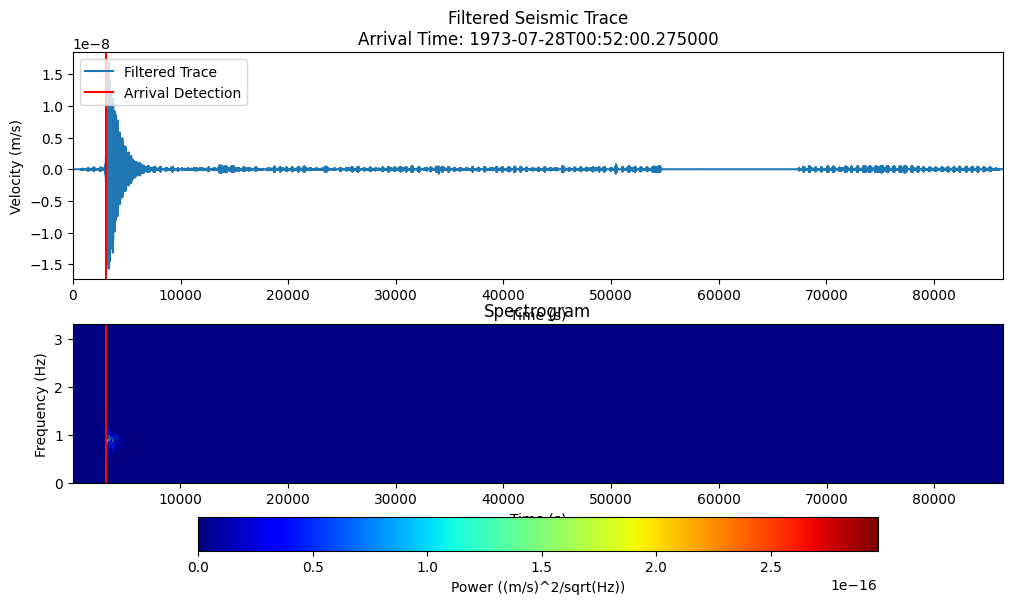

In [3]:
def convert_rel_to_abs_time(start_time, time_rel):
    """
    Convert relative time to absolute time.
    """
    return (start_time + timedelta(seconds=float(time_rel))).strftime('%Y-%m-%dT%H:%M:%S.%f')

def apply_bandpass_filter(trace, sampling_rate, freqmin=0.5, freqmax=3.0):
    """
    Apply bandpass filter to seismic trace.
    """
    sos = signal.butter(4, [freqmin, freqmax], btype='bandpass', fs=sampling_rate, output='sos')
    return signal.sosfilt(sos, trace)

def plot_trace_spectrogram_sta_lta(mseed_file, arrival_time_rel, sta_len=120, lta_len=600, thr_on=4.0, thr_off=1.5):
    """
    Load a seismic trace, apply bandpass filter, mark arrival, create spectrogram, and run STA/LTA.
    The results are plotted and displayed on screen.
    
    Parameters:
    - mseed_file: Path to the MSEED file.
    - arrival_time_rel: The relative arrival time in seconds.
    - sta_len (int): Short-Term Average window length in seconds.
    - lta_len (int): Long-Term Average window length in seconds.
    - thr_on (float): Threshold to trigger on STA/LTA.
    - thr_off (float): Threshold to trigger off STA/LTA.
    """
    # Read the MSEED file
    st = read(mseed_file)
    tr = st[0]
    tr_data = tr.data
    tr_times = tr.times()
    sampling_rate = tr.stats.sampling_rate
    starttime = tr.stats.starttime.datetime
    
    # Convert relative time to absolute
    arrival_time_abs = convert_rel_to_abs_time(starttime, arrival_time_rel)
    
    # Apply bandpass filter
    filtered_trace = apply_bandpass_filter(tr_data, sampling_rate)
    
    # Compute the spectrogram
    f, t, sxx = signal.spectrogram(filtered_trace, sampling_rate)

    # Plot filtered trace, spectrogram, and STA/LTA characteristic function
    fig = plt.figure(figsize=(12, 10))
    
    # Plot filtered trace
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(tr_times, filtered_trace, label='Filtered Trace')
    ax1.axvline(x=arrival_time_rel, color='red', label='Arrival Detection')
    ax1.set_xlim([min(tr_times), max(tr_times)])
    ax1.set_ylabel('Velocity (m/s)')
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f'Filtered Seismic Trace\nArrival Time: {arrival_time_abs}')
    ax1.legend(loc='upper left')
    
    # Plot spectrogram
    ax2 = plt.subplot(3, 1, 2)
    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, shading='gouraud')
    ax2.axvline(x=arrival_time_rel, color='red')
    ax2.set_xlim([min(t), max(t)])
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_xlabel('Time (s)')
    cbar = plt.colorbar(vals, ax=ax2, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))')
    ax2.set_title('Spectrogram')

def pick_random_trace_and_plot(data_directory, catalog):
    """
    Pick a random trace from the dataset, process it, and plot the results.
    """
    random_idx = random.randint(0, len(catalog) - 1)
    row = catalog.iloc[random_idx]
    
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']
    
    mseed_file = os.path.join(data_directory, f"{filename}.mseed")
    if os.path.exists(mseed_file):
        print(f"Processing and plotting {filename}")
        plot_trace_spectrogram_sta_lta(mseed_file, arrival_time_rel)
    else:
        print(f"MSEED file for {filename} not found in {data_directory}")

# Example usage
data_directory = '../../data/lunar_data/training/data/S12_GradeA/'
catalog_path = '../../data/lunar_data/training/catalogs/apollo12_catalog_GradeA_final.csv'

# Read the catalog
catalog = pd.read_csv(catalog_path)

# Pick a random trace and plot results
pick_random_trace_and_plot(data_directory, catalog)
